In [44]:
import math 
import pandas as pd
import random 
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Setting simulation parameters values

N = [30, 50, 75, 100, 200, 300, 500, 1000]  # population size
iter = 100 # number of iterations
time = 1440 # exposure time in minutes
T = 1

In [4]:
# importing trace

with open("/mnt/d/R0_estimation/data/trace_baseline_bernoulli.pkl", 'rb') as f:
    trace = pickle.load(f)

# extract samples from the trace

samples = trace.posterior.stack(sample=("chain", "draw"))

# extract the values of the parameters
p_sample = samples['p'].values


In [5]:
%%time 

# Perform the simulations

data = []
results = dict()# using dictionary instead of  lists

for n in N: # population size 
    for i in range(iter): # iterations
        p = p_sample[i]
        temp_results = []
        for m in range(n): # individuals
            for j in range(time):
                proba = 1 - (1 - p)**time
                
            temp_results.append(proba)

        status = [np.random.binomial(T, 1 - val) for val in temp_results] # Bernoulli drawing for infectious status (0 or 1) using the final proba
        a = [n, T] # creating the key for the dictionary
        key = str(a) # writing as a string
        try:
            results[key].append(n - status.count(0))
        except KeyError:
            results[key] = [n - status.count(0)]

CPU times: user 1min 3s, sys: 0 ns, total: 1min 3s
Wall time: 1min 3s


In [6]:
results

{'[30, 1]': [27,
  22,
  22,
  13,
  19,
  18,
  15,
  18,
  18,
  16,
  23,
  21,
  25,
  16,
  25,
  18,
  18,
  17,
  19,
  23,
  25,
  22,
  20,
  25,
  18,
  22,
  20,
  20,
  25,
  21,
  21,
  20,
  18,
  18,
  15,
  20,
  21,
  17,
  19,
  21,
  24,
  21,
  20,
  17,
  15,
  22,
  26,
  29,
  19,
  24,
  24,
  27,
  25,
  24,
  26,
  22,
  21,
  26,
  28,
  27,
  24,
  23,
  23,
  22,
  25,
  28,
  24,
  26,
  29,
  26,
  27,
  25,
  23,
  24,
  23,
  21,
  20,
  24,
  21,
  22,
  19,
  23,
  18,
  20,
  20,
  21,
  20,
  20,
  19,
  23,
  24,
  23,
  21,
  16,
  24,
  21,
  22,
  23,
  23,
  26],
 '[50, 1]': [39,
  35,
  34,
  25,
  32,
  39,
  38,
  29,
  29,
  33,
  40,
  37,
  34,
  30,
  33,
  25,
  32,
  36,
  29,
  37,
  38,
  34,
  36,
  36,
  36,
  22,
  37,
  34,
  37,
  44,
  39,
  36,
  32,
  33,
  32,
  32,
  36,
  32,
  39,
  36,
  35,
  39,
  33,
  32,
  24,
  39,
  42,
  43,
  36,
  38,
  42,
  41,
  41,
  47,
  43,
  40,
  44,
  38,
  44,
  46,
  43,
  43,
  42,

In [7]:
with open("/mnt/d/R0_estimation/output/results_bernoulli_r0.pkl", 'wb') as f:
    pickle.dump(results, f)

In [30]:
couple = list(results.keys())

In [31]:
col_names = ['Population_size', 'Infectious_time'] + [f'iter_{i}' for i in range(1, max(len(value) for value in results.values()) + 1)]

In [32]:
df = pd.DataFrame(
    [[float(couple[1:-1].split(', ')[0])] + [int(x) for x in couple[1:-1].split(', ')[1:]] + value for couple, value in results.items()],
    columns=col_names
)

In [33]:
df

,Population_size,Infectious_time,iter_1,iter_2,iter_3,iter_4,iter_5,iter_6,iter_7,iter_8,...,iter_91,iter_92,iter_93,iter_94,iter_95,iter_96,iter_97,iter_98,iter_99,iter_100
0,30.0,1,27,22,22,13,19,18,15,18,...,24,23,21,16,24,21,22,23,23,26
1,50.0,1,39,35,34,25,32,39,38,29,...,41,40,34,28,34,32,28,42,39,35
2,75.0,1,51,55,49,46,52,50,50,43,...,59,59,52,49,46,43,51,59,53,58
3,100.0,1,76,72,66,59,60,64,59,52,...,74,70,73,65,59,60,73,76,72,79
4,200.0,1,160,151,128,129,111,118,122,117,...,147,165,154,125,131,128,125,156,156,160
5,300.0,1,228,221,192,183,198,201,185,181,...,230,239,205,188,195,188,196,237,216,241
6,500.0,1,371,365,338,307,300,311,316,290,...,393,394,360,312,318,306,332,374,381,381
7,1000.0,1,763,716,678,646,576,607,610,618,...,770,772,721,646,659,625,642,765,767,773


In [39]:
# Calculate mean, standard deviation, and confidence interval
mean = df.iloc[:, 2:].mean(axis=1)
std = df.iloc[:, 2:].std(axis=1)
quantile_2_5 = df.iloc[:, 2:].quantile(0.025, axis=1)
quantile_97_5 = df.iloc[:, 2:].quantile(0.975, axis=1)


# Create new dataframe
new_df = pd.DataFrame({
    'Population_size': df['Population_size'],
    'Infectious_time': df['Infectious_time'],
    'Mean': mean,
    'Standard_deviation': std,
    'CI_2.5%': quantile_2_5,
    'CI_97.5%': quantile_97_5
})

In [40]:
new_df 

,Population_size,Infectious_time,Mean,Standard_deviation,CI_2.5%,CI_97.5%
0,30.0,1,21.74,3.404157,15.000,28.000
1,50.0,1,36.64,5.303934,25.000,46.000
2,75.0,1,55.07,7.635979,40.950,67.525
3,100.0,1,73.06,9.707666,58.475,90.050
4,200.0,1,147.22,18.509937,117.475,176.000
5,300.0,1,220.09,26.861446,178.475,265.050
6,500.0,1,367.69,43.361458,297.900,434.525
7,1000.0,1,732.99,89.025419,581.225,867.000


In [42]:
new_df['percentage'] = new_df['Mean'] / new_df['Population_size'] * 100
new_df

,Population_size,Infectious_time,Mean,Standard_deviation,CI_2.5%,CI_97.5%,percentage
0,30.0,1,21.74,3.404157,15.000,28.000,72.466667
1,50.0,1,36.64,5.303934,25.000,46.000,73.280000
2,75.0,1,55.07,7.635979,40.950,67.525,73.426667
3,100.0,1,73.06,9.707666,58.475,90.050,73.060000
4,200.0,1,147.22,18.509937,117.475,176.000,73.610000
5,300.0,1,220.09,26.861446,178.475,265.050,73.363333
6,500.0,1,367.69,43.361458,297.900,434.525,73.538000
7,1000.0,1,732.99,89.025419,581.225,867.000,73.299000


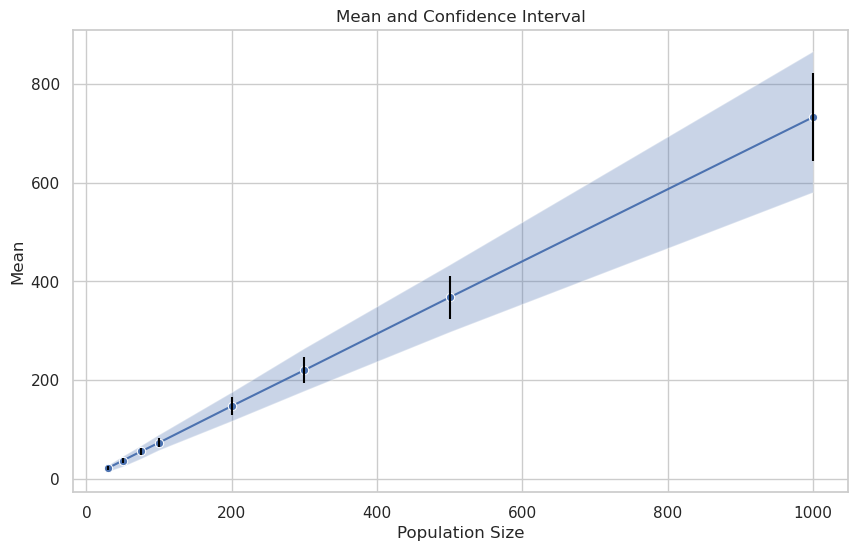

In [46]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=new_df, x='Population_size', y='Mean', marker='o')

# Plot the standard deviation as vertical lines
plt.vlines(x=new_df['Population_size'], ymin=new_df['Mean'] - new_df['Standard_deviation'], ymax=new_df['Mean'] + new_df['Standard_deviation'], color='black')

# Plot the confidence interval as a shaded region
plt.fill_between(new_df['Population_size'], new_df['CI_2.5%'], new_df['CI_97.5%'], alpha=0.3)

# Set the labels and title
plt.xlabel('Population Size')
plt.ylabel('Mean')
plt.title('Mean and Confidence Interval')

# Show the plot
plt.show()

In [47]:
import numpy as np


x = new_df['Population_size']
y = new_df['Mean']

# Fit a polynomial curve of degree 1 (linear curve)
coefficients = np.polyfit(x, y, 1)

# Get the coefficient of the curve
coefficient = coefficients[0]

# Print the coefficient
print(f"The coefficient of the curve is: {coefficient}")

The coefficient of the curve is: 0.7333855833507309


In [17]:
def calculate_r0(force_of_infection, infectious_period):
    """
    Calculate the basic reproductive number (R0) from the force of infection and the duration of the infectious period.

    Parameters:
    force_of_infection (float): The force of infection.
    infectious_period (float): The duration of the infectious period in days.

    Returns:
    float: The basic reproductive number (R0).
    """
    return force_of_infection * infectious_period

# Example usage
force_of_infection = 0.73  # 73%
infectious_period = 10  # days
r0 = calculate_r0(force_of_infection, infectious_period)
print(f"The basic reproductive number (R0) is: {r0}")

The basic reproductive number (R0) is: 7.3


In [48]:
# Save the simulation results into a csv file

df.to_csv("/mnt/d/R0_estimation/output/R0_simulation_bernoulli.csv", index=False)